## CapsNet MNIST

This is an implementation of Geoffrey Hinton's CapsNet architecture as described in [Sabour 2017]. The implementation is (very) insipired by Aurélien Géron's implementation and is for learning purposes only.

## Setup

In [27]:
# Imports
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import numpy as np
import tensorflow as tf

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import layers
import losses

from data import mnist

In [29]:
# Setup TensorBoard logdir
from datetime import datetime

In [30]:
ROOT_LOGDIR = "tf_logs"
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")

logdir = "{}/run-{}".format(ROOT_LOGDIR, now)

In [4]:
# Stabilize ouptut accross runs
# TODO give the caller more control over what to reset

def reset(seed=42):
    tf.reset_default_graph()
    np.random.seed(seed)
    tf.set_random_seed(42)

## MNIST Dataset

In [81]:
(X_train, y_train), (X_val, y_val), (X_test, y_test)= mnist.load_data()

In [82]:
max_elem = X_train.max()
min_elem = X_train.min()

X_train = (X_train - min_elem)/(max_elem - min_elem)
X_val = (X_val - min_elem)/(max_elem - min_elem)
X_test = (X_test - min_elem)/(max_elem - min_elem)

In [83]:
def peek_data(n_samples=5):
    plt.figure(figsize=(n_samples * 2, 3))
    
    for index in range(n_samples):
        plt.subplot(1, n_samples, index + 1)
        
        # images are stored as flattened numpy arrays
        sample_image = X_train[index].reshape(28, 28)
        
        plt.imshow(sample_image, cmap="binary")
        plt.axis("off")
    
    plt.show()
    
    
def peek_labels(n_samples=5):
    print(y_train[:n_samples])

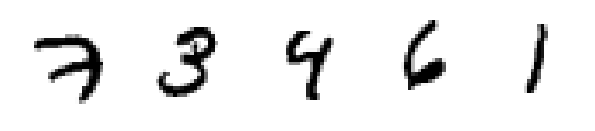

In [84]:
peek_data()

In [85]:
peek_labels()

[7 3 4 6 1]


## CapsNet model

In [95]:
tf.reset_default_graph()

In [96]:
## Inputs

X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X")
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")

In [97]:
## Model

conv1 = tf.layers.conv2d(
    X, 
    filters=256,
    kernel_size=9,
    strides=1,
    padding="valid",
    name="conv1"
)

primaryCaps = layers.convCaps(
    conv1, 
    filters=32, 
    dimensions=8,
    kernel_size=9,
    strides=2,
    activation=tf.nn.relu,
    name="primaryCaps"
)

digitCaps = layers.denseCaps(
    primaryCaps, 
    capsules=10, 
    dimensions=16
)

In [98]:
## Predictions

# The probability that a given digit is present is encoded by the length of the corresponding digit capsule
probabilities = layers.norm(digitCaps, axis=-1, name="probabilities")

with tf.variable_scope("predictions"):
    predictions = tf.argmax(probabilities, axis=-1, name="predictions")

# Classification accuracy on the sample batch
with tf.variable_scope("accuracy"):
    correct = tf.equal(y, predictions, name="correct")
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [99]:
## Reconstructions

with tf.variable_scope("reconstructions"):
    mask_with_labels = tf.placeholder_with_default(False, shape=(), name="mask_with_labels")

    reconstruction_targets = tf.cond(mask_with_labels,
                                     lambda: y,
                                     lambda: predictions,
                                     name="reconstruction_targets")

    reconstructions = layers.denseDecoder(digitCaps, reconstruction_targets, [512, 1024, 28*28], name="reconstructions")

In [100]:
## Loss
with tf.name_scope("loss"):

    with tf.variable_scope("margin_loss"):
        y_one_hot = tf.one_hot(y, depth=10, name="y_one_hot")
        margin_loss = losses.margin_loss(y_one_hot, probabilities, name="loss")

    reconstruction_loss = losses.reconstruction_loss(X, reconstructions, name="reconstruction_loss")

    alpha = tf.constant(0.0005, name="alpha")
    loss = margin_loss + alpha * reconstruction_loss

In [101]:
accuracy_summary = tf.summary.scalar('accuracy', accuracy)
margin_loss_summary = tf.summary.scalar('margin_loss', margin_loss)
reconstruction_loss_summary = tf.summary.scalar('reconstruction_loss', reconstruction_loss)
loss_summary = tf.summary.scalar('loss', loss)
summaries = tf.summary.merge_all()

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [104]:
# Training

optimizer = tf.train.AdamOptimizer()
training_op  = optimizer.minimize(loss, name="training_op")

init = tf.global_variables_initializer()


n_epochs = 100
batch_size = 1
checkpoint_path = "./capsnet_save"

X_train = X_train[:5]
y_train = y_train[:5]

X_val = X_train[:5]
y_val =y_train[:5]

n_iterations_per_epoch = len(X_train) // batch_size
n_iterations_validation = len(X_val) // batch_size

best_loss_val = np.infty

with tf.Session() as sess:
    # Initialize the graph
    init.run()

    for epoch in range(n_epochs):
        for iteration in range(n_iterations_per_epoch):
            X_batch, y_batch = X_train[iteration:iteration+batch_size+1], y_train[iteration:iteration+batch_size+1]
            
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={
                    X: X_batch.reshape([-1, 28, 28, 1]),
                    y: y_batch.reshape([-1]),
                    mask_with_labels: True
                })
        
            print(
                "\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                    iteration + 1, 
                    n_iterations_per_epoch, 
                    (iteration + 1)/n_iterations_per_epoch * 100, 
                    loss_train
                ),
                end=""
            )
        
        # Measure validation loss and accuracy at the end of each epoch:
        loss_vals = []
        acc_vals = []
        
        for iteration in range(n_iterations_validation):
            X_batch, y_batch = X_val[iteration:iteration+batch_size+1], y_val[iteration:iteration+batch_size+1]
            
            loss_val, acc_val = sess.run(
                [loss, accuracy],
                feed_dict={
                    X: X_batch.reshape([-1, 28, 28, 1]),
                    y: y_batch.reshape([-1]),
                }
            )
            
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            
            print(
                "\rEvaluating the model: {}/{} ({:.1f})%".format(
                    iteration + 1,
                    n_iterations_validation,
                    (iteration + 1) * 100 / n_iterations_validation
                ),
                end=" " * 10
            )
            
            # Log in TensorBoard
            if iteration % 10 == 0:
                summary_str = summaries.eval(
                    feed_dict={
                        X: X_batch.reshape([-1, 28, 28, 1]), 
                        y: y_batch.reshape([-1])
                    }
                )
                file_writer.add_summary(summary_str, epoch * n_iterations_validation + iteration)
            
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        
        print(
            "\rEpoch: {} Val accuracy: {:.4f}% Loss: {:.6f}{}".format(
                epoch + 1,
                acc_val * 100,
                loss_val,
                " (improved)" if loss_val < best_loss_val else ""
            )
        )
        
        
        
        # Save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

Epoch: 1 Val accuracy: 100.0000% Loss: 0.003929 (improved)
Epoch: 2 Val accuracy: 100.0000% Loss: 0.104491
Epoch: 3 Val accuracy: 100.0000% Loss: 0.000150 (improved)
Epoch: 4 Val accuracy: 100.0000% Loss: 0.004459
Epoch: 5 Val accuracy: 100.0000% Loss: 0.000647
Epoch: 6 Val accuracy: 100.0000% Loss: 0.022375
Epoch: 7 Val accuracy: 100.0000% Loss: 0.099671
Epoch: 8 Val accuracy: 100.0000% Loss: 0.003710
Epoch: 9 Val accuracy: 100.0000% Loss: 0.002642
Epoch: 10 Val accuracy: 100.0000% Loss: 0.016479
Epoch: 11 Val accuracy: 100.0000% Loss: 0.001302
Epoch: 12 Val accuracy: 100.0000% Loss: 0.000165
Epoch: 13 Val accuracy: 100.0000% Loss: 0.000152
Epoch: 14 Val accuracy: 100.0000% Loss: 0.000209
Epoch: 15 Val accuracy: 100.0000% Loss: 0.000876
Epoch: 16 Val accuracy: 100.0000% Loss: 0.000609
Epoch: 17 Val accuracy: 100.0000% Loss: 0.000399
Epoch: 18 Val accuracy: 100.0000% Loss: 0.000109 (improved)
Epoch: 19 Val accuracy: 100.0000% Loss: 0.000109 (improved)
Epoch: 20 Val accuracy: 100.0000% 

KeyboardInterrupt: 

In [17]:
file_writer.close()

In [50]:
# Testing

n_iterations_test = len(X_test) // batch_size

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    
    loss_tests = []
    acc_tests = []
    
    for iteration in range(n_iterations_test):
        X_batch, y_batch = X_test[iteration:iteration+batch_size+1], y_test[iteration:iteration+batch_size+1]
        
        loss_test, acc_test = sess.run(
            [loss, accuracy],
            feed_dict={
                X: X_batch.reshape([-1, 28, 28, 1]),
                y: y_batch.reshape([-1]),
            },
        )
        
        loss_tests.append(loss_test)
        acc_tests.append(acc_test)
        
        print(
            "\rEvaluating the model: {}/{} ({:.1f}%)".format(
                iteration + 1,
                n_iterations_test,
                (iteration + 1) * 100 / n_iterations_test
            ),
            end=" " * 10
        )
        
    loss_test = np.mean(loss_tests)
    acc_test = np.mean(acc_tests)
    
    print("\rFinal test accuracy: {:.4f}% Loss: {:.6f}".format(acc_test * 100, loss_test))

INFO:tensorflow:Restoring parameters from ./capsnet_save
Final test accuracy: 7.8125% Loss: 0.747725 


In [51]:
# Predictions

n_samples = 2

sample_images = X_train[:n_samples].reshape([-1, 28, 28, 1])

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    digitCaps_output_value, reconstructions_value, predictions_value = sess.run(
        [digitCaps, reconstructions, predictions],
        feed_dict={
            X: sample_images,
            y: np.array([], dtype=np.int64) # as explained earlier, this will not be used
        },
    )

INFO:tensorflow:Restoring parameters from ./capsnet_save


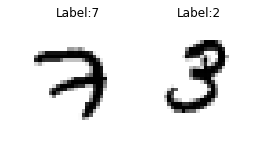

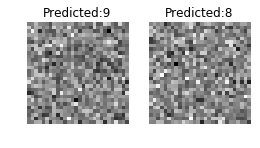

In [53]:
sample_images = sample_images.reshape([-1, 28, 28])
reconstructions_value = reconstructions_value.reshape([-1, 28, 28])

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(sample_images[index], cmap="binary")
    plt.title("Label:" + str(y_test[index]))
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(reconstructions_value[index], cmap="binary")
    plt.title("Predicted:" + str(predictions_value[index]))
    plt.axis("off")